**Natural Language Processing with RNNs and Attention**

This notebook is inspired from the handson-ml2 GitHub repository by Aurélien Geron

https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
tf.get_logger().setLevel(logging.ERROR)

import tensorflow_hub as hub

# Reusing Pretrained Embeddings

In [2]:
tf.random.set_seed(42)

In [3]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

Here is a simple example of how to work with the `nnlm-en-dim50` module:

In [ ]:
# embed1 = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")
# embeddings1 = embed1(["cat is on the mat", "dog is in the fog"])

In [5]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50/2")
embeddings = embed(["cat is on the mat", "dog is in the fog"])
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.16589954,  0.0254965 ,  0.1574857 ,  0.17688066,  0.02911299,
        -0.03092718,  0.19445257, -0.05709129, -0.08631689, -0.04391516,
         0.13032274,  0.10905275, -0.08515751,  0.01056632, -0.17220995,
        -0.17925954,  0.19556305,  0.0802278 , -0.03247919, -0.49176937,
        -0.07767699, -0.03160921, -0.13952136,  0.05959712,  0.06858718,
         0.22386682, -0.16653948,  0.19412343, -0.05491862,  0.10997339,
        -0.15811177, -0.02576607, -0.07910853, -0.258499  , -0.04206644,
        -0.20052543,  0.1705603 , -0.15314153,  0.0039225 , -0.28694248,
         0.02468278,  0.11069503,  0.03733957,  0.01433943, -0.11048374,
         0.11931834, -0.11552787, -0.11110869,  0.02384969, -0.07074881],
       [ 0.1437864 ,  0.08291595,  0.10897306,  0.04464385, -0.03630389,
        -0.12605834,  0.20263346,  0.12862863, -0.07873426, -0.01195358,
         0.0020956 , -0.03080653, -0.08019945, -0.18797135, -0.11973457,
 

...and here are the embeddings:

In [6]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.16589954,  0.0254965 ,  0.1574857 ,  0.17688066,  0.02911299,
        -0.03092718,  0.19445257, -0.05709129, -0.08631689, -0.04391516,
         0.13032274,  0.10905275, -0.08515751,  0.01056632, -0.17220995,
        -0.17925954,  0.19556305,  0.0802278 , -0.03247919, -0.49176937,
        -0.07767699, -0.03160921, -0.13952136,  0.05959712,  0.06858718,
         0.22386682, -0.16653948,  0.19412343, -0.05491862,  0.10997339,
        -0.15811177, -0.02576607, -0.07910853, -0.258499  , -0.04206644,
        -0.20052543,  0.1705603 , -0.15314153,  0.0039225 , -0.28694248,
         0.02468278,  0.11069503,  0.03733957,  0.01433943, -0.11048374,
         0.11931834, -0.11552787, -0.11110869,  0.02384969, -0.07074881],
       [ 0.1437864 ,  0.08291595,  0.10897306,  0.04464385, -0.03630389,
        -0.12605834,  0.20263346,  0.12862863, -0.07873426, -0.01195358,
         0.0020956 , -0.03080653, -0.08019945, -0.18797135, -0.11973457,
 

Now let's implement this in our Sentiment Analysis model:

- The `hub.KerasLayer` layer downloads the module from the given URL. This particular module is a sentence encoder: it takes strings as input and encodes each one as a single vector (in this case, a 50-dimensional vector).
- We can then add two simple `Dense` layers to create a good sentiment analysis model.
- By default, a `hub.KerasLayer` is not trainable, but you can set `trainable=True` when creating it to change that so that you can fine-tune it for your task.

In [4]:
import tensorflow_hub as hub


In [11]:
kl = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50])


In [21]:
def dist(a, b):
    return tf.reduce_sum(tf.square(a - b)).numpy()


In [22]:
result = kl(np.array(["frog", "toad", "human"]))
good = result[0]
nice = result[1]
bad = result[2]
print(dist(good, nice))
print(dist(good, bad))

0.4695334
1.2785239


In [23]:
def sides(kl, p1, p2, p3):
    result = kl(np.array([p1, p2, p3]))
    pp1, pp2, pp3 = result[0], result[1], result[2]
    print(p1 + " <> " + p2, dist(pp1, pp2))
    print(p2 + " <> " + p3, dist(pp2, pp3))
    print(p1 + " <> " + p3, dist(pp1, pp3))

In [24]:
sides(kl, "frog", "toad", "cat")

frog <> toad 0.4695334
toad <> cat 0.7622121
frog <> cat 0.79006547


In [25]:
sides(kl, "king", "queen", "woman")

king <> queen 0.82297397
queen <> woman 0.7447315
king <> woman 1.3321736


In [26]:
sides(kl, "king", "queen", "man")

king <> queen 0.82297397
queen <> man 0.93395174
king <> man 0.89384246


In [19]:
r = dist(good, bad)

In [20]:
r.numpy()

1.2785239

In [7]:
import tensorflow_hub as hub

model = keras.Sequential([
    # The last part of the URL specified that we wanted version 1 of the model.
    # This versioning ensures that if a new module version is released, it will not break our model.
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [8]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/74a841d6eb84e8d93d913d716fb5440d020cc291.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt
./my_tfhub_cache/74a841d6eb84e8d93d913d716fb5440d020cc291/saved_model.pb
./my_tfhub_cache/74a841d6eb84e8d93d913d716fb5440d020cc291/variables/variables.index
./my_tfhub_cache/74a841d6eb84e8d93d913d716fb5440d020cc291/variables/variables.data-00000-of-00001
./my_tfhub_cache/74a841d6eb84e8d93d913d716fb5440d020cc291/assets/tokens.txt


Now load the IMDb reviews dataset and directly train the model, no need to preprocess it (except for batching and prefetching).

In [9]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", data_dir='/cxldata/dlcourse', as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)

In [10]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [11]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [12]:
# history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=10)
# np.save('history/pretrained_embedding.npy', history.history)
# model.save("models/pretrained_embedding.h5")

In [22]:
model.load_weights("/cxldata/dlcourse/models/pretrained_embedding.h5")

In [23]:
model(np.array(["it was a great movie."]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7244715]], dtype=float32)>

In [24]:
model(np.array(["this movie sucks"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3167267]], dtype=float32)>

In [25]:
model(np.array(["this movie is pathetic"]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.17415127]], dtype=float32)>

In [ ]:
model(np.array(["this movie is pathetic"]))

**Go Back to the Slides**

## Automatic Translation

### Basic Encoder–Decoder model

In [10]:
tf.random.set_seed(42)

In [11]:
vocab_size = 100
embed_size = 10

In [12]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

# We set return_state=True when creating the LSTM layer so that  we can get its final
# hidden state and pass it to the decoder.
encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# TrainingSampler() tell the decoder at each step what it should pretend the previous output was.
# During inference, this should be the embedding of the token that was actually output.
# During training, it should be the embedding of the previous target token.
# This is why we used the TrainingSampler()
sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

Since we are using an `LSTM` cell, it actually returns two hidden states (short term and long term).

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [14]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Train on 1000 samples
Epoch 1/2
1000/1000 [==============================] - 5s 5ms/sample - loss: 4.6050
Epoch 2/2
1000/1000 [==============================] - 2s 2ms/sample - loss: 4.6038


**Go Back to the Slides**

### Bidirectional Recurrent Layers

The following `Bidirectional` layer will create a clone of the `GRU` layer (but in the reverse direction), and it will run both and concatenate their outputs. So although the `GRU` layer has 10 units, the `Bidirectional` layer will output 20 values per time step.

In [15]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    # The following line of code creates a bidirectional GRU layer
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


**Go Back to the Slides**

# Attention Mechanisms

## Positional Embeddings

For efficiency reasons, we precompute the positional embedding matrix in the constructor (so we need to know the maximum sentence length, `max_steps`, and the number of dimensions for each word representation, `max_dims`).

Then the `call()` method crops this embedding matrix to the size of the inputs, and it adds it to the inputs.

In [16]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

Since we added an extra first dimension of size 1 when creating the positional embedding matrix, the rules of broadcasting will ensure that the matrix gets added to every sentence in the inputs.

**Following is a visual representation of positional embeddings**

In [17]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

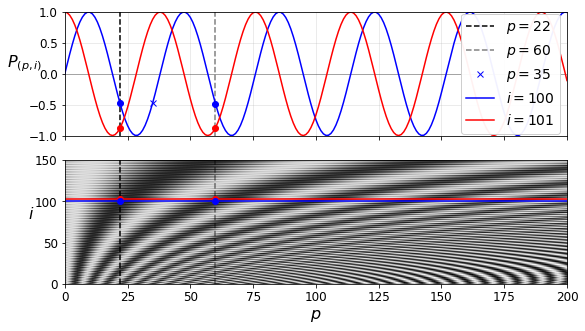

In [18]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()

Now we will create the first layers of the Transformer:

In [19]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

**Go Back to the Slides**

## Multi-Head Attention

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [20]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    # The use_scale=True argument creates an additional parameter that lets the layer 
    # learn how to properly downscale the similarity scores
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

**Go Back to the Slides**

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [21]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [22]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

**Go Back to the Slides**